## Canny 算法从头实现

Canny 是 1986 年发明的边缘检测算法。至今仍在计算机视觉中占有很大的作用。Canny 是一个多阶段的算法，主要包括下面几方面：

+ 灰度化
+ 高斯滤波
+ 计算梯度
+ 非极大值抑制
+ 双阈值算法

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2

In [2]:
class Canny():
    
    def __init__(self):
        
        pass
    
    # 灰度化
    def gray(self, img_path):
        """
        Calculate function:
        Gray(i,j) = [R(i,j) + G(i,j) + B(i,j)] / 3
        or :
        Gray(i,j) = 0.299 * R(i,j) + 0.587 * G(i,j) + 0.114 * B(i,j)
        """
        # 读取图片
        img = plt.imread(img_path)
        # 转换成 RGB 格式
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # 灰度化
        img_gray = np.dot(img_rgb[...,:3], [0.299, 0.587, 0.114])
        
        return img_gray
    
    # 去除噪音 - 使用 5x5 的高斯滤波器
    def smooth(self, img_gray):
        
        # 生成高斯滤波器
        """
        要生成一个 (2k+1)x(2k+1) 的高斯滤波器，滤波器的各个元素计算公式如下：
        
        H[i, j] = (1/(2*pi*sigma**2))*exp(-1/2*sigma**2((i-k-1)**2 + (j-k-1)**2))
        """
        sigma1 = sigma2 = 1.4
        gau_sum = 0
        gaussian = np.zeros([5, 5])
        for i in range(5):
            for j in range(5):
                gaussian[i, j] = math.exp((-1/(2*sigma1*sigma2))*(np.square(i-3) 
                                + np.square(j-3)))/(2*math.pi*sigma1*sigma2)
                gau_sum =  gau_sum + gaussian[i, j]
                
        # 归一化处理
        gaussian = gaussian / gau_sum
        
        # 高斯滤波
        W, H = img_gray.shape
        new_gray = np.zeros([W-5, H-5])
        
        for i in range(W-5):
            for j in range(H-5):
                new_gray[i, j] = np.sum(img_gray[i:i+5, j:j+5] * gaussian)
                
        return new_gray
    
    # 计算梯度幅值
    def gradients(self, new_gray):
        
        W, H = new_gray.shape
        dx = np.zeros([W-1, H-1])
        dy = np.zeros([W-1, H-1])
        M = np.zeros([W-1, H-1])
        theta = np.zeros([W-1, H-1])
        
        for i in range(W-1):
            for j in range(H-1):
                dx[i, j] = new_gray[i+1, j] - new_gray[i, j]
                dy[i, j] = new_gray[i, j+1] - new_gray[i, j]
                M[i, j] = np.sqrt(np.square(dx[i, j]) + np.square(dy[i, j])) # 图像梯度幅值作为图像强度值
                theta[i, j] = math.atan(dx[i, j] / (dy[i, j] + 0.000000001)) # 计算 slope θ - artan(dx/dy)
                
        return dx, dy, M, theta
    
    # 非极大值抑制 NMS
    
    def NMS(self, M, dx, dy):
        
        d = np.copy(M)
        W, H = M.shape
        NMS = np.copy(d)
        NMS[0, :] = NMS[W-1, :] = NMS[:, 0] = NMS[:, H-1] = 0
        
        for i in range(1, W-1):
            for j in range(1, H-1):
                
                # 如果当前梯度为0，该点就不是比边缘点
                if M[i, j] == 0:
                    NMS[i, j] = 0
                    
                else:
                    gradX = dx[i, j] # 当前点 x 方向导数
                    gradY = dy[i, j] # 当前点 y 方向导数
                    gradTemp = d[i, j] # 当前梯度点
                    
                    # 如果 y 方向梯度值比较大，说明导数方向趋向于 y 分量
                    if np.abs(gradY) > np.abs(gradX):
                        weight = np.abs(gradX) / np.abs(gradY) # 权重
                        grad2 = d[i-1, j]
                        grad4 = d[i+1, j]
                        
                        # 如果 x, y 方向导数符号一致
                        # 像素点位置关系
                        # g1 g2
                        #    c
                        #    g4 g3
                        if gradX * gradY > 0:
                            grad1 = d[i-1, j-1]
                            grad3 = d[i+1, j+1]
                        
                        # 如果 x，y 方向导数符号相反
                        # 像素点位置关系
                        #    g2 g1
                        #    c
                        # g3 g4
                        else:
                            grad1 = d[i-1, j+1]
                            grad3 = d[i+1, j-1]
                    
                    # 如果 x 方向梯度值比较大
                    else:
                        weight = np.abs(gradY) / np.abs(gradX)
                        grad2 = d[i, j-1]
                        grad4 = d[i, j+1]
                        
                        # 如果 x, y 方向导数符号一致
                        # 像素点位置关系
                        # g1
                        # g2 c g4
                        #      g3
                        if gradX * gradY > 0:
                            grad1 = d[i-1, j-1]
                            grad3 = d[i+1, j+1]
                        
                        # 如果 x，y 方向导数符号相反
                        # 像素点位置关系
                        #      g3
                        # g2 c g4
                        # g1
                        else:
                            grad1 = d[i+1, j-1]
                            grad3 = d[i-1, j+1]
                            
                    # 利用 grad1-grad4 对梯度进行插值
                    gradTemp1 = weight * grad1 + (1 - weight) * grad2
                    gradTemp2 = weight * grad3 + (1 - weight) * grad4
                    
                    # 当前像素的梯度是局部的最大值，可能是边缘点
                    if gradTemp >= gradTemp1 and gradTemp >= gradTemp2:
                        NMS[i, j] = gradTemp
                        
                    else:
                        # 不可能是边缘点
                        NMS[i, j] = 0
                        
        return NMS
    
    def double_threshold(self, NMS):
        
        W, H = NMS.shape
        DT = np.zeros([W, H])
        
        # 定义高低阈值
        TL = 0.1 * np.max(NMS)
        TH = 0.3 * np.max(NMS)
        
        for i in range(1, W-1):
            for j in range(1, H-1):
                if (NMS[i, j] < TL):
                    DT[i, j] = 0
                    
                elif (NMS[i, j] > TH):
                    DT[i, j] = 1
                    
                # 
                elif (NMS[i-1, j-1:j+1] < TH).any() or (NMS[i+1, j-1:j+1].any()
                        or (NMS[i, [j-1, j+1]] < TH).any()):
                    DT[i, j] = 1
                    
        
        return DT    

(300, 281)


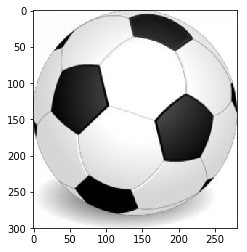

In [3]:
canny = Canny()
img_gray = canny.gray("D:/cv作业/image-alignment/football.jpg")
print(img_gray.shape)
plt.imshow(img_gray, cmap="gray")

In [4]:
new_gray = canny.smooth(img_gray)
print(new_gray.shape)

(295, 276)


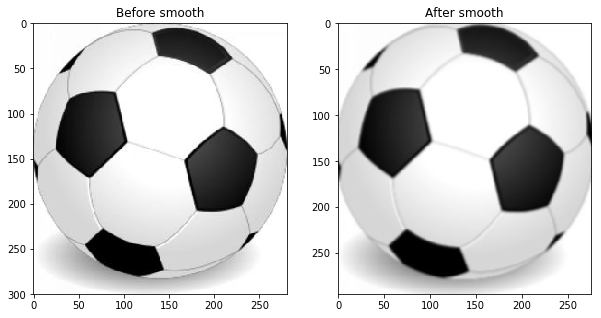

In [5]:
plt.figure(figsize=(10, 8))
plt.subplot(1,2,1)
plt.title("Before smooth")
plt.imshow(img_gray, cmap="gray")
plt.subplot(1,2,2)
plt.title("After smooth")
plt.imshow(new_gray, cmap="gray")

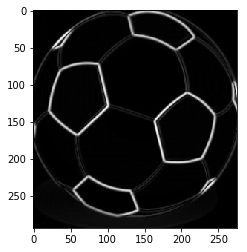

In [6]:
M = canny.gradients(new_gray)[2]
plt.imshow(M, cmap="gray")

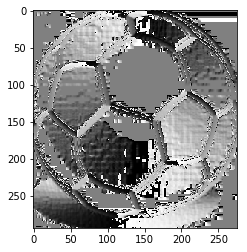

In [7]:
theta = canny.gradients(new_gray)[3]
plt.imshow(theta, cmap="gray")

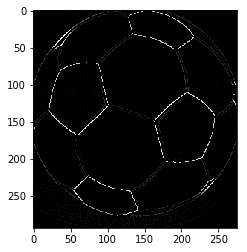

In [8]:
dx = canny.gradients(new_gray)[0]
dy = canny.gradients(new_gray)[1]
NMS = canny.NMS(M, dx, dy)
plt.imshow(NMS, cmap="gray")

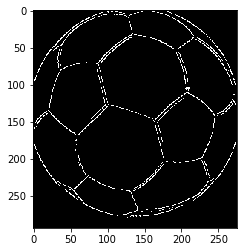

In [9]:
DT = canny.double_threshold(NMS)
plt.imshow(DT, cmap="gray")

In [14]:
def edge_detection(img_path):

    canny = Canny()
    img_gray = canny.gray(img_path)
    new_gray = canny.smooth(img_gray)
    dx, dy, M, _ = canny.gradients(new_gray)
    NMS = canny.NMS(M, dx, dy)
    DT = canny.double_threshold(NMS) 
    plt.imshow(DT, cmap="gray")

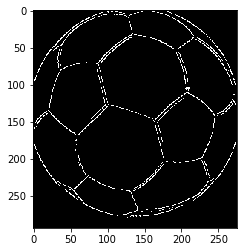

In [15]:
edge_detection("D:/cv作业/image-alignment/football.jpg")

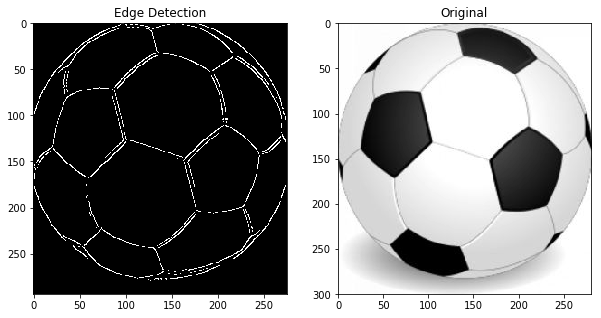

In [25]:
# 读取图片
img = plt.imread("D:/cv作业/image-alignment/football.jpg")

new = canny.smooth(img)
dx, dy, M, _ = canny.gradients(new)
NMS = canny.NMS(M, dx, dy)
DT = canny.double_threshold(NMS) 
plt.figure(figsize=(10, 8))
plt.subplot(121)
plt.title("Edge Detection")
plt.imshow(DT, cmap="gray")
plt.subplot(122)
plt.title("Original")
plt.imshow(img, cmap="gray")

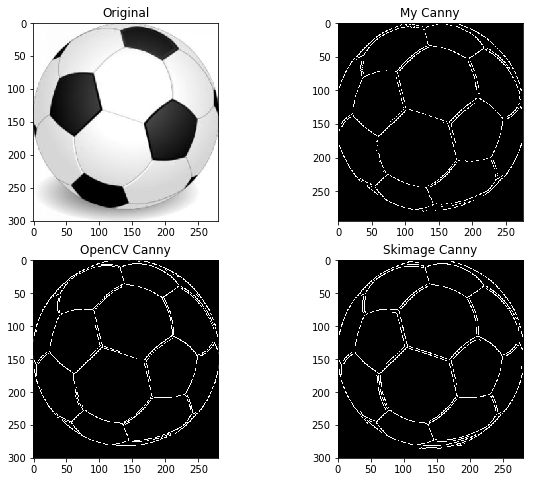

In [32]:
# 与其他结果进行对比
plt.figure(figsize=(10, 8))

# 原图
img = plt.imread("D:/cv作业/image-alignment/football.jpg")
plt.subplot(221)
plt.title("Original")
plt.imshow(img, cmap="gray")

# 自己算法的结果
plt.subplot(222)
plt.title("My Canny")
plt.imshow(DT, cmap="gray")

# OpenCV 的结果
plt.subplot(223)
plt.title("OpenCV Canny")
cv_edges = cv2.Canny(img, 100, 200)
plt.imshow(cv_edges, cmap="gray")

# Skimage 的结果
from skimage import feature
plt.subplot(224)
plt.title("Skimage Canny")
sk_edges = feature.canny(img)
plt.imshow(sk_edges, cmap="gray")